## Código da última aula...

In [14]:
import math, random, heapq, time
import torch
import torch.nn as nn
import torch.nn.functional as F


# =========================
# Utilidades básicas
# =========================
def set_seed(s=42):
    """
    Define semente para reprodutibilidade de experimentos
    (Python, PyTorch CPU e CUDA).
    """
    random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)

set_seed(7)

# Seleciona automaticamente GPU (se disponível) ou CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def shape(x, name=None):
    """
    Helper para depuração: imprime shape, dtype e device de um tensor.
    Útil para verificar se as dimensões estão como esperado em cada etapa.
    """
    tag = f"[{name}] " if name else ""
    print(f"{tag}shape={tuple(x.shape)} dtype={x.dtype} device={x.device}")


# =========================
# 1) Máscaras
# =========================
def causal_mask(seq_len, device=None):
    """
    Gera máscara causal (triangular inferior), usada para impedir que
    o decodificador "olhe" posições futuras.

    Retorna:
        Tensor (1, 1, seq, seq) com 1=permitido e 0=proibido (futuro).
    """
    m = torch.tril(torch.ones(seq_len, seq_len, dtype=torch.uint8, device=device))
    return m.view(1, 1, seq_len, seq_len)


def padding_mask(token_ids, pad_token_id=0):
    """
    Cria máscara para ignorar posições de padding em uma sequência.

    Parâmetros:
        token_ids: (B, seq) com IDs de tokens.
        pad_token_id: ID usado para <pad>.

    Retorna:
        (B, 1, 1, seq) com 1=token válido e 0=PAD.
    """
    return (token_ids != pad_token_id).unsqueeze(1).unsqueeze(2).to(torch.uint8)


# =========================
# 2) Positional Encoding (senoidal)
# =========================
class SinusoidalPositionalEncoding(nn.Module):
    """
    Codificação posicional senoidal (Vaswani et al., 2017).
    Fornece informação de posição ao Transformer (que é paralelo e
    não possui ordem intrínseca).
    """
    def __init__(self, d_model, max_len=5000, device=None):
        super().__init__()
        # Matriz de posições: (max_len, d_model)
        pe = torch.zeros(max_len, d_model, device=device)

        # Vetor de posições: (max_len, 1)
        pos = torch.arange(0, max_len, dtype=torch.float, device=device).unsqueeze(1)

        # Frequências: termos 1/10000^(2i/d_model) para i par
        div = torch.exp(
            torch.arange(0, d_model, 2, device=device).float() * (-math.log(10000.0) / d_model)
        )

        # Preenche dimensões pares com seno e ímpares com cosseno
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)

        # Guarda como buffer (não-treinável), com dimensão de batch fictícia
        # (1, max_len, d_model) para facilitar broadcast com (B, seq, d_model).
        self.register_buffer("pe", pe.unsqueeze(0), persistent=False)
        self.d_model = d_model

    def forward(self, x):
        """
        Soma a codificação posicional aos embeddings.

        Parâmetros:
            x: (B, seq, d_model)
        Retorna:
            (B, seq, d_model) = x + PE[:seq]
        """
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]


# =========================
# 3) Multi-Head Attention
# =========================
class MultiHeadAttention(nn.Module):
    """
    Implementa a atenção multi-cabeças:
      - Projeta Q, K, V para h cabeças menores (d_k/d_v),
      - Calcula atenção escalonada por cabeça,
      - Concatena e projeta de volta para d_model.
    """
    def __init__(self, d_model=512, num_heads=8, dropout=0.1, bias=True, return_attn_weights=True):
        super().__init__()
        assert d_model % num_heads == 0, "d_model deve ser múltiplo de num_heads"
        self.d_model = d_model
        self.h = num_heads
        self.d_k = d_model // num_heads
        self.d_v = d_model // num_heads
        self.return_attn_weights = return_attn_weights

        # Projeções aprendidas para Q, K e V (antes de dividir em cabeças)
        self.W_Q = nn.Linear(d_model, d_model, bias=bias)
        self.W_K = nn.Linear(d_model, d_model, bias=bias)
        self.W_V = nn.Linear(d_model, d_model, bias=bias)

        # Projeção de saída (concatenação das cabeças → d_model)
        self.W_O = nn.Linear(d_model, d_model, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def _split_heads(self, x):
        """
        Reorganiza (B, T, d_model) → (B, h, T, d_k)
        para processar as cabeças em paralelo.
        """
        B, T, _ = x.shape
        return x.view(B, T, self.h, self.d_k).transpose(1, 2)

    def _combine_heads(self, x):
        """
        Inverso de _split_heads:
        (B, h, T, d_v) → (B, T, h*d_v) = (B, T, d_model)
        """
        B, h, T, dv = x.shape
        return x.transpose(1, 2).contiguous().view(B, T, h * dv)

    def forward(self, Q_in, K_in, V_in, attn_mask=None):
        """
        Parâmetros:
            Q_in, K_in, V_in: (B, seq, d_model)
            attn_mask: (B, 1 ou h, Tq, Tk) com 1=permitido, 0=proibido
        Retorna:
            out: (B, Tq, d_model)
            attn (opcional): (B, h, Tq, Tk) — pesos de atenção por cabeça
        """
        B, Tq, _ = Q_in.shape
        _,  Tk, _ = K_in.shape

        # Projeções e divisão em cabeças
        Q = self._split_heads(self.W_Q(Q_in))  # (B, h, Tq, d_k)
        K = self._split_heads(self.W_K(K_in))  # (B, h, Tk, d_k)
        V = self._split_heads(self.W_V(V_in))  # (B, h, Tk, d_v)

        # Similaridade escalonada: Q · K^T / sqrt(d_k)
        scores = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.d_k)  # (B, h, Tq, Tk)

        # Aplica máscara: posições proibidas recebem -inf (softmax → 0)
        if attn_mask is not None:
            scores = scores.masked_fill(attn_mask == 0, float("-inf"))

        # Distribuição de atenção por cabeça
        attn = F.softmax(scores, dim=-1)   # (B, h, Tq, Tk)
        attn = self.dropout(attn)

        # Combina atenção com valores: saída por cabeça (B, h, Tq, d_v)
        heads_out = torch.matmul(attn, V)

        # Concatena cabeças e projeta de volta para d_model
        concat = self._combine_heads(heads_out)  # (B, Tq, d_model)
        out = self.W_O(concat)                   # (B, Tq, d_model)

        if self.return_attn_weights:
            return out, attn
        return out


# =========================
# 4) FFN posição-a-posição
# =========================
class PositionwiseFFN(nn.Module):
    """
    MLP aplicada independentemente a cada posição (token):
    Linear(d_model→d_ff) → ReLU/GELU → Dropout → Linear(d_ff→d_model)
    """
    def __init__(self, d_model=512, d_ff=2048, dropout=0.1):
        super().__init__()
        self.lin1 = nn.Linear(d_model, d_ff)
        self.lin2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.act = nn.ReLU()  # poderia ser nn.GELU() (comum em BERT)

    def forward(self, x):
        """
        x: (B, seq, d_model) → (B, seq, d_model)
        """
        return self.lin2(self.dropout(self.act(self.lin1(x))))


# =========================
# 5) EncoderLayer e DecoderLayer
# =========================
class EncoderLayer(nn.Module):
    """
    Um bloco do Encoder: Self-Attention + FFN (cada um com Add & Norm).
    """
    def __init__(self, d_model=512, num_heads=8, d_ff=2048, dropout=0.1, return_attn_weights=False):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads, dropout, return_attn_weights=return_attn_weights)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)

        self.ffn = PositionwiseFFN(d_model, d_ff, dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)

        self.return_attn = return_attn_weights

    def forward(self, x, src_mask=None):
        """
        x: (B, seq, d_model)
        src_mask: (B,1,1,seq) ou (B,h,seq,seq), 1=permitido, 0=pad/bloqueio
        """
        # Self-Attention (Q=K=V=x)
        mha_out, attn = self.mha(x, x, x, attn_mask=src_mask)
        x = self.norm1(x + self.dropout1(mha_out))   # Add & Norm

        # Feed-Forward posição-a-posição
        ffn_out = self.ffn(x)
        x = self.norm2(x + self.dropout2(ffn_out))   # Add & Norm

        if self.return_attn:
            return x, attn
        return x


class DecoderLayer(nn.Module):
    """
    Um bloco do Decoder:
      1) Masked Self-Attn (autoregressiva),
      2) Cross-Attn (Q do decoder, K/V do encoder),
      3) FFN,
    cada qual seguido por Add & Norm.
    """
    def __init__(self, d_model=512, num_heads=8, d_ff=2048, dropout=0.1, return_attn_weights=False):
        super().__init__()
        self.self_mha = MultiHeadAttention(d_model, num_heads, dropout, return_attn_weights=return_attn_weights)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)

        self.cross_mha = MultiHeadAttention(d_model, num_heads, dropout, return_attn_weights=return_attn_weights)
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)

        self.ffn = PositionwiseFFN(d_model, d_ff, dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.norm3 = nn.LayerNorm(d_model)

        self.return_attn = return_attn_weights

    def forward(self, x, memory, tgt_mask=None, memory_mask=None):
        """
        x: (B, tgt_seq, d_model) — sequência alvo parcial
        memory: (B, src_seq, d_model) — saída do encoder
        tgt_mask: (B,1,tgt,tgt) causal ∧ padding
        memory_mask: (B,1,tgt,src) padding mask do source expandida
        """
        # 1) Masked Self-Attention (autoregressiva)
        self_out, self_attn = self.self_mha(x, x, x, attn_mask=tgt_mask)
        x = self.norm1(x + self.dropout1(self_out))

        # 2) Cross-Attention (decoder consulta o encoder)
        cross_out, cross_attn = self.cross_mha(x, memory, memory, attn_mask=memory_mask)
        x = self.norm2(x + self.dropout2(cross_out))

        # 3) Feed-Forward
        ffn_out = self.ffn(x)
        x = self.norm3(x + self.dropout3(ffn_out))

        if self.return_attn:
            return x, {"self": self_attn, "cross": cross_attn}
        return x


# =========================
# 6) MiniTransformer (Encoder+Decoder + weight tying)
# =========================
class MiniTransformer(nn.Module):
    """
    Modelo seq2seq minimalista no estilo Transformer (Encoder-Decoder).
    Inclui:
      - Embeddings + PE
      - Pilhas de EncoderLayer e DecoderLayer
      - Projeção final para logits de vocabulário (com weight tying)
    """
    def __init__(self, vocab_size, d_model=512, num_heads=8, d_ff=2048, num_layers=2, dropout=0.1,
                 pad_token_id=0, max_len=256, return_attn_weights=False, device=None):
        super().__init__()
        self.d_model = d_model
        self.pad_token_id = pad_token_id
        self.device = device

        # Embeddings + Positional Encoding
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pe = SinusoidalPositionalEncoding(d_model, max_len=max_len, device=device)
        self.dropout = nn.Dropout(dropout)

        # Pilhas Encoder/Decoder
        self.encoder = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout, return_attn_weights=return_attn_weights)
            for _ in range(num_layers)
        ])
        self.decoder = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout, return_attn_weights=return_attn_weights)
            for _ in range(num_layers)
        ])

        # Projeção final para logits sobre o vocabulário
        self.proj = nn.Linear(d_model, vocab_size, bias=False)

        # Weight tying: compartilha pesos entre embedding e projeção
        self.proj.weight = self.tok_emb.weight

        # Escalonamento sugerido pelo paper
        self.scale = math.sqrt(d_model)
        self.return_attn = return_attn_weights

    # --- Encode / Decode / Forward ---
    def encode(self, src_ids):
        """
        Codifica a sequência de entrada.
        Retorna:
          memory: (B, n, d_model) — representações do encoder
          src_mask: (B,1,1,n) — padding mask do source
          enc_attn: lista de mapas de atenção por camada (se habilitado)
        """
        # src_ids: (B, n)
        src_mask = padding_mask(src_ids, pad_token_id=self.pad_token_id)  # (B,1,1,n)

        x = self.tok_emb(src_ids) * self.scale
        x = self.pe(x)
        x = self.dropout(x)

        enc_attn = []
        for layer in self.encoder:
            out = layer(x, src_mask=src_mask)
            if isinstance(out, tuple):
                x, attn = out
                enc_attn.append(attn)
            else:
                x = out
        return x, src_mask, enc_attn  # memory, mask, atenções

    def decode(self, tgt_ids, memory, src_mask):
        """
        Decodifica a sequência alvo condicionada à memória do encoder.
        Retorna:
          logits: (B, m, |V|)
          dec_attn: lista de dicts {"self":(B,h,m,m), "cross":(B,h,m,n)} por camada
        """
        # tgt_ids: (B, m)
        B, m = tgt_ids.shape

        # Máscara causal (B,1,m,m) e padding do target (B,1,1,m)
        causal = causal_mask(m, device=tgt_ids.device)                    # (1,1,m,m)
        tgt_pad = padding_mask(tgt_ids, pad_token_id=self.pad_token_id)   # (B,1,1,m)
        tgt_mask = causal & tgt_pad                                       # broadcast → (B,1,m,m)

        # Memory mask: expande padding do source para cada posição de tgt: (B,1,m,n)
        memory_mask = src_mask.expand(B, 1, m, src_mask.size(-1))

        x = self.tok_emb(tgt_ids) * self.scale
        x = self.pe(x)
        x = self.dropout(x)

        dec_attn = []
        for layer in self.decoder:
            out = layer(x, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
            if isinstance(out, tuple):
                x, attn = out
                dec_attn.append(attn)
            else:
                x = out

        logits = self.proj(x)  # (B, m, |V|)
        return logits, dec_attn

    def forward(self, src_ids, tgt_ids):
        """
        Pipeline completo: encode(source) → decode(target | memory)
        Retorna:
          logits e (opcionalmente) mapas de atenção de encoder e decoder.
        """
        memory, src_mask, enc_attn = self.encode(src_ids)
        logits, dec_attn = self.decode(tgt_ids, memory, src_mask)
        return logits, {"enc": enc_attn, "dec": dec_attn}


###############  Daqui em diante é material novo. Explicaremos a seguir ###############

# =========================
# 7) Loss com label smoothing
# =========================
class LabelSmoothingLoss(nn.Module):
    """
    Implementação de cross-entropy com label smoothing.
    Suaviza a distribuição-alvo para reduzir overfitting e calibrar probabilidades.
    """
    def __init__(self, eps=0.1, ignore_index=0, reduction="mean"):
        super().__init__()
        self.eps = eps
        self.ignore_index = ignore_index
        self.reduction = reduction

    def forward(self, logits, target):
        """
        Parâmetros:
            logits: (B, T, V) — scores não normalizados do decoder
            target: (B, T)    — IDs verdadeiros (alvos)
        Retorna:
            Escalar de loss (por padrão, média sobre tokens não-pad).
        """
        B, T, V = logits.shape
        logits = logits.view(B*T, V)
        target = target.view(B*T)

        # Ignora posições com <pad>
        mask = (target != self.ignore_index)
        if not mask.any():
            # Evita NaN se tudo for pad
            return torch.tensor(0.0, device=logits.device, requires_grad=True)

        valid_logits = logits[mask]
        valid_target = target[mask]

        # Constrói distribuição-alvo suavizada
        with torch.no_grad():
            true_dist = torch.zeros_like(valid_logits)
            true_dist.fill_(self.eps / (V - 1))
            true_dist.scatter_(1, valid_target.unsqueeze(1), 1.0 - self.eps)

        # CE com distribuição suavizada
        log_probs = F.log_softmax(valid_logits, dim=-1)
        loss = -(true_dist * log_probs).sum(dim=-1)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss


# =========================
# 8) Noam scheduler
# =========================
class NoamScheduler:
    """
    Agendador de taxa de aprendizado do Transformer original:
      lrate = d_model^-0.5 * min(step^-0.5, step * warmup^-1.5)
    Cresce linearmente até warmup_steps e depois decai como 1/sqrt(step).
    """
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup = warmup_steps
        self.step_num = 0

    def step(self):
        """
        Avança um passo no agendador e atualiza a LR do otimizador.
        Retorna a LR atual (útil para logging).
        """
        self.step_num += 1
        lr = (self.d_model ** -0.5) * min(
            self.step_num ** -0.5,
            self.step_num * (self.warmup ** -1.5)
        )
        for p in self.optimizer.param_groups:
            p['lr'] = lr
        return lr


# =========================
# 9) Dataset sintético (cópia) + loader simples
# =========================
PAD, BOS, EOS = 0, 1, 2

def gen_sequence(vocab_size=50, min_len=4, max_len=12):
    """
    Gera uma sequência aleatória de IDs (evitando PAD/BOS/EOS).
    """
    L = random.randint(min_len, max_len)
    return [random.randint(3, vocab_size-1) for _ in range(L)]  # evita PAD/BOS/EOS


def make_example(vocab_size=50, min_len=4, max_len=12):
    """
    Tarefa de cópia: alvo = cópia do source.
    Usa:
      tgt_in  = [BOS] + src
      tgt_out = src + [EOS]
    """
    src = gen_sequence(vocab_size, min_len, max_len)
    tgt_in  = [BOS] + src[:]
    tgt_out = src[:] + [EOS]
    return src, tgt_in, tgt_out


def pad_batch(batch, pad_id=PAD):
    """
    Faz padding uniforme em um lote de exemplos de tamanhos variáveis.
    Retorna tensores (B, max_len) para src, tgt_in, tgt_out.
    """
    max_src  = max(len(s)  for s,_,__ in batch)
    max_tin  = max(len(ti) for _,ti,__ in batch)
    max_tout = max(len(to) for _,__,to in batch)

    src_ids, tgt_in_ids, tgt_out_ids = [], [], []
    for s, ti, to in batch:
        src_ids.append(s  + [pad_id]*(max_src  - len(s)))
        tgt_in_ids.append(ti + [pad_id]*(max_tin - len(ti)))
        tgt_out_ids.append(to + [pad_id]*(max_tout- len(to)))
    return (torch.tensor(src_ids, dtype=torch.long),
            torch.tensor(tgt_in_ids, dtype=torch.long),
            torch.tensor(tgt_out_ids, dtype=torch.long))


def data_iter(num_batches=200, batch_size=32, vocab_size=50):
    """
    Iterador simples que gera lotes de dados sintéticos com padding.
    Útil para testar pipeline de treino/decoding.
    """
    for _ in range(num_batches):
        batch = [make_example(vocab_size=vocab_size) for _ in range(batch_size)]
        yield pad_batch(batch)


# =========================
# 10) Decodificadores (greedy e beam)
# =========================
@torch.no_grad()
def greedy_decode(model, src_ids, max_len=50):
    """
    Decodificação gulosa (greedy): escolhe argmax a cada passo.
    Observação: para uso didático; beam search costuma gerar sequências melhores.
    """
    model.eval()
    memory, src_mask, _ = model.encode(src_ids)
    B = src_ids.size(0)
    ys = torch.full((B, 1), BOS, dtype=torch.long, device=src_ids.device)
    for _ in range(max_len):
        logits, _ = model.decode(ys, memory, src_mask)
        next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True)  # (B,1)
        ys = torch.cat([ys, next_token], dim=1)
        if (next_token == EOS).all():
            break
    return ys


def length_penalty(length, alpha=0.6):
    """
    Penalidade de comprimento (Google NMT):
      LP = ((5 + length) / 6)^alpha
    Ajuda o beam a não favorecer sequências muito curtas.
    """
    return ((5 + length) / 6) ** alpha


@torch.no_grad()
def beam_search_decode(model, src_ids, beam_size=4, max_len=50, alpha=0.6):
    """
    Beam search didático para batch=1.
    Mantém 'beam_size' hipóteses com melhores scores (neg-log prob),
    aplicando penalidade de comprimento para normalizar a comparação.
    """
    model.eval()
    assert src_ids.size(0) == 1, "Implementação didática assume batch=1"
    memory, src_mask, _ = model.encode(src_ids)

    # Cada item do beam: (score_acumulado, sequência_gerada)
    beams = [(0.0, torch.tensor([[BOS]], device=src_ids.device))]
    completed = []

    for _ in range(max_len):
        new_beams = []
        for score, seq in beams:
            # Se já finalizou com EOS, movemos para 'completed'
            if seq[0, -1].item() == EOS:
                completed.append((score, seq))
                continue

            # Expande um passo a partir da sequência atual
            logits, _ = model.decode(seq, memory, src_mask)
            log_probs = F.log_softmax(logits[:, -1, :], dim=-1)  # (1, V)

            # Seleciona top-k candidatos
            topk = torch.topk(log_probs, beam_size, dim=-1)
            for lp, tok in zip(topk.values[0], topk.indices[0]):
                new_seq = torch.cat([seq, tok.view(1,1)], dim=1)
                new_score = score - lp.item()  # acumulamos -log p (menor é melhor)
                new_beams.append((new_score, new_seq))

        # Ordena por score normalizado com length penalty e mantém top-k
        def norm_key(item):
            s, seq = item
            L = seq.size(1)
            return s / length_penalty(L, alpha)

        beams = sorted(new_beams, key=norm_key)[:beam_size]
        if len(beams) == 0:
            break

    # Considera também os beams restantes não finalizados
    completed.extend(beams)

    # Escolhe a melhor sequência pelo score normalizado
    best = min(completed, key=lambda x: x[0] / length_penalty(x[1].size(1), alpha))
    return best[1]


print("Bootstrap do modelo carregado ✔")

Bootstrap do modelo carregado ✔


## 1) Por que **label smoothing**?
Sem smoothing, a *cross-entropy* empurra probabilidade 100% para o rótulo correto (one-hot). Isso pode causar **overconfidence** e prejudicar generalização.  
**Label smoothing** (ε) “distribui” uma pequena massa nos demais rótulos:
- Distribuição-alvo vira: `1−ε` no rótulo correto, `ε/(|V|−1)` nos demais.
- Efeito: **regularização**; melhora BLEU/accuracy mesmo **piorando perplexidade** (o modelo fica menos “certo” numericamente, mas erra menos). 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LabelSmoothingLoss(nn.Module):
    """
    Implementação de cross-entropy com label smoothing.
    Suaviza a distribuição-alvo para reduzir overfitting e calibrar probabilidades.
    """
    def __init__(self, eps=0.1, ignore_index=0, reduction="mean"):
        super().__init__()
        self.eps = eps
        self.ignore_index = ignore_index
        self.reduction = reduction

    def forward(self, logits, target):
        """
        Parâmetros:
            logits: (B, T, V) — scores não normalizados do decoder
            target: (B, T)    — IDs verdadeiros (alvos)
        Retorna:
            Escalar de loss (por padrão, média sobre tokens não-pad).
        """
        B, T, V = logits.shape
        logits = logits.view(B*T, V)
        target = target.view(B*T)

        # Ignora posições com <pad>
        mask = (target != self.ignore_index)
        if not mask.any():
            # Evita NaN se tudo for pad
            return torch.tensor(0.0, device=logits.device, requires_grad=True)

        valid_logits = logits[mask]
        valid_target = target[mask]

        # Constrói distribuição-alvo suavizada
        with torch.no_grad():
            true_dist = torch.zeros_like(valid_logits)
            true_dist.fill_(self.eps / (V - 1))
            true_dist.scatter_(1, valid_target.unsqueeze(1), 1.0 - self.eps)

        # CE com distribuição suavizada
        log_probs = F.log_softmax(valid_logits, dim=-1)
        loss = -(true_dist * log_probs).sum(dim=-1)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss

## 2) Otimizador e **Noam LR Schedule**
O paper usa **Adam** com **β₁=0.9, β₂=0.98, ε=1e−9** e um agendamento:
$$
\text{lrate} = d_{model}^{-0.5} \cdot \min(\text{step}^{-0.5},\ \text{step}\cdot \text{warmup}^{-1.5})
$$
- **Aquecimento (warmup)**: cresce linearmente até `warmup_steps` e depois decai ∝ `1/√step`.  
- **Valores do paper**: warmup=4000 (modelo base). 

In [ ]:
import math
from torch.optim import Adam

class NoamScheduler:
    """
    Agendador de taxa de aprendizado do Transformer original:
      lrate = d_model^-0.5 * min(step^-0.5, step * warmup^-1.5)
    Cresce linearmente até warmup_steps e depois decai como 1/sqrt(step).
    """
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup = warmup_steps
        self.step_num = 0

    def step(self):
        """
        Avança um passo no agendador e atualiza a LR do otimizador.
        Retorna a LR atual (útil para logging).
        """
        self.step_num += 1
        lr = (self.d_model ** -0.5) * min(
            self.step_num ** -0.5,
            self.step_num * (self.warmup ** -1.5)
        )
        for p in self.optimizer.param_groups:
            p['lr'] = lr
        return lr

# Exemplo de uso:
# optimizer = Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)
# scheduler = NoamScheduler(optimizer, d_model=512, warmup_steps=4000)
# for ...:
#     loss.backward(); optimizer.step(); optimizer.zero_grad()
#     lr = scheduler.step()

## 3) Dataset sintético: **tarefa de cópia**
Para demonstrar o pipeline completo sem depender de corpus grande, usamos uma tarefa simples:  
**Entrada = sequência aleatória de tokens** (sem <pad> dentro), **Saída = a mesma sequência deslocada** (teacher forcing).

- `<bos>` e `<eos>` delimitam início/fim no target.
- Mostramos *masking* do `<pad>` na perda.
- Em poucas iterações dá pra ver a perda caindo e o modelo **memorizando** a cópia.

In [4]:
import torch
import random

PAD, BOS, EOS = 0, 1, 2

def gen_sequence(vocab_size=50, min_len=4, max_len=12):
    L = random.randint(min_len, max_len)
    # tokens em [3, vocab_size-1], evitando PAD/BOS/EOS
    seq = [random.randint(3, vocab_size-1) for _ in range(L)]
    return seq

def make_example(vocab_size=50, min_len=4, max_len=12):
    src = gen_sequence(vocab_size, min_len, max_len)
    tgt_in = [BOS] + src[:]         # teacher forcing input
    tgt_out = src[:] + [EOS]        # o que queremos prever
    return src, tgt_in, tgt_out

def pad_batch(batch, pad_id=PAD):
    # batch: list of (src, tgt_in, tgt_out)
    max_src = max(len(s) for s,_,__ in batch)
    max_tin = max(len(ti) for _,ti,__ in batch)
    max_tout= max(len(to) for _,__,to in batch)

    src_ids = []
    tgt_in_ids = []
    tgt_out_ids = []

    for s, ti, to in batch:
        src_ids.append(s + [pad_id]*(max_src - len(s)))
        tgt_in_ids.append(ti + [pad_id]*(max_tin - len(ti)))
        tgt_out_ids.append(to + [pad_id]*(max_tout - len(to)))

    return (torch.tensor(src_ids, dtype=torch.long),
            torch.tensor(tgt_in_ids, dtype=torch.long),
            torch.tensor(tgt_out_ids, dtype=torch.long))

def data_iter(num_batches=200, batch_size=32, vocab_size=50):
    for _ in range(num_batches):
        batch = [make_example(vocab_size=vocab_size) for _ in range(batch_size)]
        yield pad_batch(batch)

## 4) Amarrando tudo: modelo + perda + otimizador + scheduler
- Usaremos seu **MiniTransformer** (ou o da aula anterior), com:
  - embeddings escaladas por `√d_model`,
  - **PE senoidal** somada,
  - pilha de **EncoderLayer**/**DecoderLayer**,
  - *weight tying* entre embedding e projeção final.
- Perda: **LabelSmoothingLoss(ε=0.1)**, ignorando `<pad>`.
- Otimizador: **Adam(β₁=0.9, β₂=0.98, ε=1e−9)**, LR controlado pelo **NoamScheduler**.

In [5]:
import math
import time
import torch

# Hiperparâmetros didáticos (pequenos para rodar rápido)
VOCAB_SIZE = 64
D_MODEL    = 128
N_HEADS    = 4
D_FF       = 512
N_LAYERS   = 2
DROPOUT    = 0.1
WARMUP     = 400   # menor que 4000 só para ver a curva mexer rápido
BATCH_SIZE = 64
NUM_BATCH  = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MiniTransformer(
    vocab_size=VOCAB_SIZE, d_model=D_MODEL, num_heads=N_HEADS, d_ff=D_FF,
    num_layers=N_LAYERS, dropout=DROPOUT, pad_token_id=PAD, max_len=128,
    return_attn_weights=False, device=device
).to(device)

criterion = LabelSmoothingLoss(eps=0.1, ignore_index=PAD)
optimizer = Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)
scheduler = NoamScheduler(optimizer, d_model=D_MODEL, warmup_steps=WARMUP)

# Atenções retornando (out, attn) para bater com o desempacotamento do Encoder/Decoder

# Encoder: ligar pesos nas self-attn
for layer in model.encoder:
    if hasattr(layer, "mha"):
        layer.mha.return_attn_weights = True

# Decoder: ligar pesos nas self-attn e cross-attn
for layer in model.decoder:
    if hasattr(layer, "self_mha"):
        layer.self_mha.return_attn_weights = True
    if hasattr(layer, "cross_mha"):
        layer.cross_mha.return_attn_weights = True

def shift_targets_for_loss(tgt_out):
    """
    Garantimos que logits (B,T,|V|) alinhem com tgt_out (B,T).
    Nosso decode já produz logits alinhados com tgt_in, então ok.
    """
    return tgt_out

losses = []
lrs = []

start = time.time()
model.train()
for i, (src, tgt_in, tgt_out) in enumerate(data_iter(num_batches=NUM_BATCH, batch_size=BATCH_SIZE, vocab_size=VOCAB_SIZE), 1):
    src = src.to(device)
    tgt_in = tgt_in.to(device)
    tgt_out = shift_targets_for_loss(tgt_out.to(device))

    optimizer.zero_grad()
    logits, _ = model(src, tgt_in)       # (B, T, V)
    loss = criterion(logits, tgt_out)    # mascara PAD internamente
    loss.backward()

    # (Opcional) clipping para estabilidade
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    lr = scheduler.step()

    losses.append(loss.item())
    lrs.append(lr)

    if i % 20 == 0:
        dt = time.time() - start
        print(f"[{i:04d}/{NUM_BATCH}] loss={loss.item():.4f}  lr={lr:.6f}  ({dt:.1f}s)")
        start = time.time()

print("Treino finalizado.")

[0020/200] loss=27.9931  lr=0.000221  (3.2s)
[0040/200] loss=10.5540  lr=0.000442  (2.3s)
[0060/200] loss=6.6749  lr=0.000663  (2.2s)
[0080/200] loss=5.6498  lr=0.000884  (2.2s)
[0100/200] loss=4.7260  lr=0.001105  (2.2s)
[0120/200] loss=4.1890  lr=0.001326  (2.2s)
[0140/200] loss=3.9550  lr=0.001547  (2.2s)
[0160/200] loss=3.7974  lr=0.001768  (2.5s)
[0180/200] loss=3.6977  lr=0.001989  (2.6s)
[0200/200] loss=3.6150  lr=0.002210  (2.4s)
Treino finalizado.


## 5) Visualizando perda e learning rate
Vamos plotar:
- **Perda por batch** (espera-se queda clara na tarefa de cópia)
- **Learning rate** ao longo dos passos (Noam schedule)

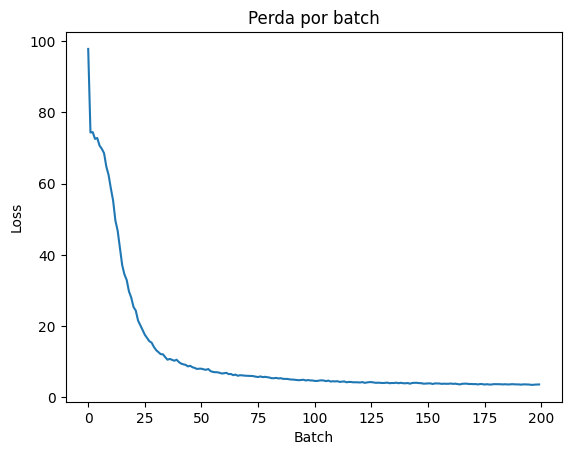

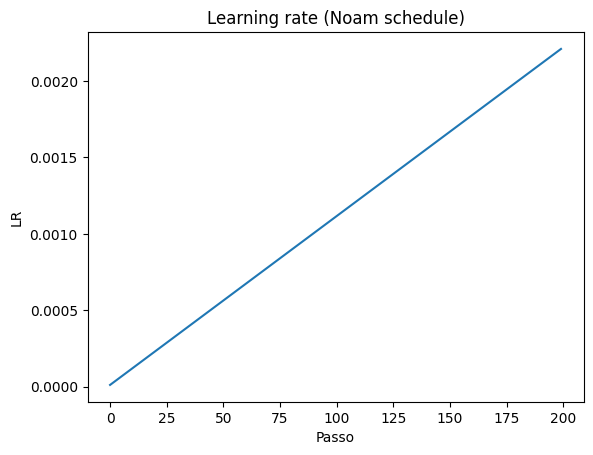

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.plot(losses)
plt.title("Perda por batch")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(lrs)
plt.title("Learning rate (Noam schedule)")
plt.xlabel("Passo")
plt.ylabel("LR")
plt.show()

## 6) Decodificação: **greedy** e **beam search** com length penalty

- **Greedy**: escolhe o argmax a cada passo; rápido, porém pode “miopizar” a sequência.
- **Beam search**: mantém os `k` melhores **prefixos**; controla **exploração** vs **exploração local**.
- **Length penalty (α)**: corrige o viés a sequências curtas/longas. O paper usou **α=0.6**. 

In [7]:
@torch.no_grad()
def greedy_decode(model, src_ids, max_len=50):
    """
    src_ids: (B, n)
    Retorna sequência decodificada para cada item do batch.
    """
    model.eval()
    memory, src_mask, _ = model.encode(src_ids)
    B = src_ids.size(0)
    ys = torch.full((B, 1), BOS, dtype=torch.long, device=src_ids.device)  # começa com <BOS>

    for _ in range(max_len):
        logits, _ = model.decode(ys, memory, src_mask)
        next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True)  # último passo
        ys = torch.cat([ys, next_token], dim=1)
        # parada antecipada se todos emitirem EOS
        if (next_token == EOS).all():
            break
    return ys

In [8]:
import heapq
import math

def length_penalty(length, alpha=0.6):
    # Como no GNMT / paper (α=0.6), penaliza/prolonga adequadamente
    return ((5 + length) / 6) ** alpha

@torch.no_grad()
def beam_search_decode(model, src_ids, beam_size=4, max_len=50, alpha=0.6):
    """
    Implementação simples de beam search (batch=1 para didática).
    """
    model.eval()
    assert src_ids.size(0) == 1, "Implementação didática assume batch=1"
    memory, src_mask, _ = model.encode(src_ids)

    # cada hipótese: (score_negativo, seq_tensor)
    # usamos log-prob acumulada negativa para usar heapq como min-heap
    init = torch.tensor([[BOS]], device=src_ids.device)
    beams = [(0.0, init)]
    completed = []

    for step in range(max_len):
        new_beams = []
        for score, seq in beams:
            if seq[0, -1].item() == EOS:
                completed.append((score, seq))
                continue
            logits, _ = model.decode(seq, memory, src_mask)
            log_probs = F.log_softmax(logits[:, -1, :], dim=-1)  # (1, V)
            topk = torch.topk(log_probs, beam_size, dim=-1)
            for lp, tok in zip(topk.values[0], topk.indices[0]):
                new_seq = torch.cat([seq, tok.view(1,1)], dim=1)
                new_score = score - lp.item()  # lembrando: score = - Σ log p
                new_beams.append((new_score, new_seq))

        # seleciona os K melhores pelo score normalizado por length penalty
        def normalized_key(item):
            score, seq = item
            L = seq.size(1)
            return score / length_penalty(L, alpha)

        beams = sorted(new_beams, key=normalized_key)[:beam_size]

        # critério: se todos encerraram
        if len(beams) == 0:
            break

    completed.extend(beams)
    best = min(completed, key=lambda x: x[0] / length_penalty(x[1].size(1), alpha))
    return best[1]

## 7) Teste rápido de decodificação

Vamos criar uma sequência de entrada (aleatória), treinar mais algumas iterações (se preciso),
e comparar **greedy** vs **beam search** (α=0.6).

In [9]:
# Uma fonte ao acaso
src_seq, tgt_in_seq, tgt_out_seq = make_example(vocab_size=VOCAB_SIZE)
src = torch.tensor([src_seq], device=device)

# Greedy
out_greedy = greedy_decode(model, src, max_len=64)
print("Greedy:", out_greedy[0].tolist())

# Beam
out_beam = beam_search_decode(model, src, beam_size=4, max_len=64, alpha=0.6)
print("Beam  :", out_beam[0].tolist())

Greedy: [1, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
Beam  : [1, 2]


In [10]:
# ============================================================
# Treinar e comparar esperado vs gerado
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

# 1) Corpus de texto simples (use o que quiser aqui; só mantenha tokens no vocabulário)
TEXT_CORPUS = [
    "o gato preto correu .",
    "o cachorro branco dormiu .",
    "a gata preta pulou .",
    "o gato dormiu .",
    "o cachorro correu .",
    "a gata branca correu .",
    "o gato preto pulou .",
    "a gata dormiu .",
    "o cachorro pulou .",
    "o gato correu .",
    "o melhor time do mundo é o cruzeiro .",
    "santos é nome de cidade .",
]

# 2) Construir vocabulário (com seus especiais PAD/BOS/EOS)
#    Usa tokenização por espaço, mantendo '.' como token
def _tok(s): 
    return s.strip().lower().split()

unique_tokens = set()
for s in TEXT_CORPUS:
    unique_tokens.update(_tok(s))

# Garante que '.' esteja presente mesmo se não aparecer nos exemplos
unique_tokens.update([".", ","])

# Monta vocab/ivocab incluindo especiais
# Se você já tem 'vocab' e 'ivocab' globais para OUTROS usos, aqui criamos versões
# específicas deste demo de texto, para não conflitar: vocab_txt / ivocab_txt.
vocab_txt = {"<pad>": PAD, "<bos>": BOS, "<eos>": EOS}
next_id = max(vocab_txt.values()) + 1
for w in sorted(unique_tokens):
    if w not in vocab_txt:
        vocab_txt[w] = next_id
        next_id += 1
ivocab_txt = {i:w for w,i in vocab_txt.items()}

def encode_text_txt(text, add_bos=True, add_eos=True, device=None):
    toks = _tok(text)
    ids = []
    if add_bos: ids.append(BOS)
    oov = []
    for t in toks:
        if t in vocab_txt:
            ids.append(vocab_txt[t])
        else:
            oov.append(t)
            ids.append(PAD)  # fallback didático; melhor seria tratar <unk> separado
    if add_eos: ids.append(EOS)
    if oov:
        print(f"[Aviso] Tokens fora do vocabulário: {oov}")
    dev = device if device is not None else next(model.parameters()).device
    return torch.tensor([ids], dtype=torch.long, device=dev)

def decode_ids_txt(ids_tensor):
    ids = ids_tensor.squeeze(0).tolist()
    toks = []
    for i in ids:
        if i == BOS: 
            continue
        if i == EOS:
            break
        toks.append(ivocab_txt.get(i, "<unk>"))
    return " ".join(toks)

# 3) Dataset de cópia (texto -> texto)
def make_text_batch(batch_size=32, device=None):
    dev = device if device is not None else next(model.parameters()).device
    src_list, tgt_in_list, tgt_out_list = [], [], []
    for _ in range(batch_size):
        s = random.choice(TEXT_CORPUS)
        src_ids = encode_text_txt(s, add_bos=True, add_eos=True, device=dev)      # (1, n)
        tgt_in  = encode_text_txt(s, add_bos=True, add_eos=False, device=dev)      # <bos> + tokens
        tgt_out = encode_text_txt(s, add_bos=False, add_eos=True, device=dev)      # tokens + <eos>
        src_list.append(src_ids.squeeze(0))
        tgt_in_list.append(tgt_in.squeeze(0))
        tgt_out_list.append(tgt_out.squeeze(0))
    src = pad_sequence(src_list, batch_first=True, padding_value=PAD)
    tgt_in  = pad_sequence(tgt_in_list, batch_first=True, padding_value=PAD)
    tgt_out = pad_sequence(tgt_out_list, batch_first=True, padding_value=PAD)
    return src, tgt_in, tgt_out

# 4) Instanciar um novo modelo para TEXTO (não sobrescreve seu 'model' anterior)
#    Importante: return_attn_weights=True para bater com o Encoder/Decoder atuais.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VOCAB_TXT = len(vocab_txt)

model_txt = MiniTransformer(
    vocab_size=VOCAB_TXT,
    d_model=D_MODEL,           # reutiliza seus hyperparams definidos acima
    num_heads=N_HEADS,
    d_ff=D_FF,
    num_layers=N_LAYERS,
    dropout=DROPOUT,
    pad_token_id=PAD,
    max_len=128,
    return_attn_weights=True,  # <- necessário dado o desempacotamento (out, attn)
    device=device
).to(device)

criterion_txt = LabelSmoothingLoss(eps=0.1, ignore_index=PAD)
optimizer_txt = torch.optim.Adam(model_txt.parameters(), betas=(0.9, 0.98), eps=1e-9)
scheduler_txt = NoamScheduler(optimizer_txt, d_model=D_MODEL, warmup_steps=WARMUP)

# 5) Treino curto no corpus textual (tarefa de cópia)
NUM_BATCH_TXT = 200
BATCH_SIZE_TXT = 64
model_txt.train()
losses_txt, lrs_txt = [], []
t0 = time.time()
for step in range(1, NUM_BATCH_TXT+1):
    src, tgt_in, tgt_out = make_text_batch(BATCH_SIZE_TXT, device=device)
    optimizer_txt.zero_grad()
    logits, _ = model_txt(src, tgt_in)   # (B, T, V)
    loss = criterion_txt(logits, tgt_out)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model_txt.parameters(), 1.0)
    optimizer_txt.step()
    lr = scheduler_txt.step()
    losses_txt.append(loss.item()); lrs_txt.append(lr)
    if step % 20 == 0:
        dt = time.time() - t0
        print(f"[texto {step:03d}/{NUM_BATCH_TXT}] loss={loss.item():.4f}  lr={lr:.6f}  ({dt:.1f}s)")
        t0 = time.time()

print("Treino (texto) finalizado.")

# 6) Predição (greedy) e comparação: Entrada x Esperada x Gerada
@torch.no_grad()
def greedy_decode_txt(model, src_ids, max_len=40):
    model.eval()
    memory, src_mask, _ = model.encode(src_ids)
    ys = torch.tensor([[BOS]], device=src_ids.device, dtype=torch.long)
    for _ in range(max_len):
        logits, _ = model.decode(ys, memory, src_mask)  # (B, t, V)
        next_id = logits[:, -1, :].argmax(dim=-1, keepdim=True)
        ys = torch.cat([ys, next_id], dim=1)
        if (next_id == EOS).all():
            break
    return ys

def demo_compare(sentences):
    print("\n================= DEMO (TEXTO) =================")
    for s in sentences:
        src = encode_text_txt(s, add_bos=True, add_eos=True, device=device)
        out_ids = greedy_decode_txt(model_txt, src, max_len=40)
        out_text = decode_ids_txt(out_ids)
        print(f"Entrada:          {s}")
        print(f"Saída esperada:   {s}")     # tarefa de cópia
        print(f"Saída gerada:     {out_text}")
        print("-"*48)

# 7) Rodar a comparação em várias entradas
TESTE = [
    "o gato preto correu .",
    "a gata branca correu .",
    "o cachorro branco dormiu .",
    "o gato dormiu .",
    "o cachorro pulou .",
]
demo_compare(TESTE)

[texto 020/200] loss=15.1084  lr=0.000221  (2.4s)
[texto 040/200] loss=4.6911  lr=0.000442  (2.1s)
[texto 060/200] loss=2.4095  lr=0.000663  (2.2s)
[texto 080/200] loss=1.3448  lr=0.000884  (2.1s)
[texto 100/200] loss=1.0756  lr=0.001105  (2.1s)
[texto 120/200] loss=0.9646  lr=0.001326  (2.1s)
[texto 140/200] loss=0.9317  lr=0.001547  (2.1s)
[texto 160/200] loss=0.8387  lr=0.001768  (2.3s)
[texto 180/200] loss=0.8133  lr=0.001989  (2.3s)
[texto 200/200] loss=0.7566  lr=0.002210  (2.4s)
Treino (texto) finalizado.

================= DEMO (TEXTO) =================
Entrada:          o gato preto correu .
Saída esperada:   o gato preto correu .
Saída gerada:     o gato preto correu .
------------------------------------------------
Entrada:          a gata branca correu .
Saída esperada:   a gata branca correu .
Saída gerada:     a gata branca correu .
------------------------------------------------
Entrada:          o cachorro branco dormiu .
Saída esperada:   o cachorro branco dormiu .
S

In [11]:
# ============================================================
# PREDICT-ONLY
# ============================================================

import torch

# Checagens mínimas (evita redefinir qualquer coisa)
if "model_txt" not in globals():
    raise RuntimeError("Não encontrei 'model_txt'. Rode o bloco de treino/instanciação anterior primeiro.")

for name in ("encode_text_txt", "decode_ids_txt", "greedy_decode_txt", "vocab_txt", "ivocab_txt", "BOS", "EOS", "PAD"):
    if name not in globals():
        raise RuntimeError(f"Dependência ausente: {name}. Rode o bloco anterior para definir.")

@torch.no_grad()
def predict_text(inputs, max_len=40, topk=None):
    """
    inputs: str ou list[str] com frases já no vocabulário 'vocab_txt'.
    max_len: limite de geração (tokens incluindo <eos>).
    topk: se int (ex. 5), mostra top-k do último passo para cada frase.
    """
    if isinstance(inputs, str):
        inputs = [inputs]

    dev = next(model_txt.parameters()).device
    print("\n================= PREDICT (TEXTO) =================")
    for s in inputs:
        # encode -> greedy -> decode
        src_ids = encode_text_txt(s, add_bos=True, add_eos=True, device=dev)
        out_ids = greedy_decode_txt(model_txt, src_ids, max_len=max_len)
        out_text = decode_ids_txt(out_ids)

        print(f"Entrada:         {s}")
        print(f"Saída gerada:    {out_text}")

        # opcional: top-k do último passo
        if isinstance(topk, int) and topk > 0:
            # recalcula só o último passo para extrair probs
            memory, src_mask, _ = model_txt.encode(src_ids)
            ys = torch.tensor([[BOS]], device=dev, dtype=torch.long)
            last_logits = None
            for _ in range(max_len):
                last_logits, _ = model_txt.decode(ys, memory, src_mask)  # (1, t, V)
                step_logits = last_logits[:, -1, :]                       # (1, V)
                next_id = step_logits.argmax(dim=-1, keepdim=True)        # (1,1)
                ys = torch.cat([ys, next_id], dim=1)
                if (next_id == EOS).all():
                    break
            if last_logits is not None:
                probs = torch.softmax(step_logits, dim=-1)[0]             # (V,)
                vals, idxs = torch.topk(probs, k=min(topk, probs.numel()))
                toks = [ivocab_txt.get(i.item(), "<unk>") for i in idxs]
                print("Top-{} do último passo:".format(len(toks)))
                for t, p in zip(toks, vals.tolist()):
                    print(f"  {t:<12} p={p:.4f}")
        print("-" * 48)

# =========================
# EXEMPLOS DE USO
# =========================
testes = [
    "o gato preto correu .",
    "a gata branca correu .",
    "o cachorro branco dormiu .",
    "o gato dormiu .",
    "o cachorro pulou .",
]
predict_text(testes, max_len=40, topk=5)

# Ou testar uma única frase:
# predict_text("o gato preto pulou .", max_len=40, topk=5)


================= PREDICT (TEXTO) =================
Entrada:         o gato preto correu .
Saída gerada:    o gato preto correu .
Top-5 do último passo:
  <eos>        p=0.8977
  gato         p=0.0077
  ,            p=0.0066
  santos       p=0.0063
  branca       p=0.0056
------------------------------------------------
Entrada:         a gata branca correu .
Saída gerada:    a gata branca correu .
Top-5 do último passo:
  <eos>        p=0.9033
  ,            p=0.0071
  branca       p=0.0068
  santos       p=0.0067
  gata         p=0.0056
------------------------------------------------
Entrada:         o cachorro branco dormiu .
Saída gerada:    o cachorro branco dormiu .
Top-5 do último passo:
  <eos>        p=0.9022
  santos       p=0.0078
  ,            p=0.0066
  branca       p=0.0054
  gata         p=0.0053
------------------------------------------------
Entrada:         o gato dormiu .
Saída gerada:    o gato dormiu .
Top-5 do último passo:
  <eos>        p=0.8890
  gato      

In [12]:
predict_text("o gato", max_len=40, topk=5)


================= PREDICT (TEXTO) =================
Entrada:         o gato
Saída gerada:    o gato preto pulou .
Top-5 do último passo:
  <eos>        p=0.9140
  santos       p=0.0077
  branca       p=0.0058
  ,            p=0.0057
  cruzeiro     p=0.0050
------------------------------------------------


In [13]:
predict_text("quem é o melhor time do mundo?", max_len=40, topk=5)


================= PREDICT (TEXTO) =================
[Aviso] Tokens fora do vocabulário: ['quem', 'mundo?']
Entrada:         quem é o melhor time do mundo?
Saída gerada:    o melhor time do mundo é o cruzeiro .
Top-5 do último passo:
  <eos>        p=0.9158
  santos       p=0.0090
  do           p=0.0060
  branca       p=0.0049
  cidade       p=0.0046
------------------------------------------------
